In [1]:
# import the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [19]:
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [3]:
d = r"D:\Mask-detection\dataset"
category = ["with_mask", "without_mask"]

In [4]:
# load the dataset
# add images and labels to the list
images = []
labels = []
for c in category:
    path = os.path.join(d, c)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)

        # set pixels to range [-1, 1] for mobilenetV2
        image = preprocess_input(image) 
        
        images.append(image)
        labels.append(c)


C:\python\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
# encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# convert the list into numpy array
data = np.array(images)
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


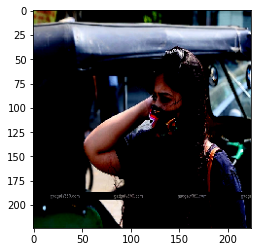

In [6]:
# sample image
plt.imshow(data[1500])

In [7]:
# sample label
labels[0]

array([1., 0.], dtype=float32)

In [8]:
# split the dataset into training and testing
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=16)

In [9]:
# split the training dataset into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, stratify=y_train, random_state=19)

In [10]:
dataAug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [11]:
# create the model
# base model
baseModel = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# head model
headModel = baseModel.output
headModel = GlobalAveragePooling2D(name="head_pooling")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
# stack the head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
# loop over all layers in the base model and freeze them
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
# complie the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [16]:
h = model.fit(
    dataAug.flow(x_train, y_train, batch_size = 32),
    steps_per_epoch = len(x_train)//32,
    validation_data = (x_val, y_val),
    validation_steps = len(x_val)//32,
    epochs = 10
)

Epoch 1/10
81/81 [==============================] - 60s 688ms/step - loss: 0.1142 - accuracy: 0.9584 - val_loss: 0.0900 - val_accuracy: 0.9630
Epoch 2/10
81/81 [==============================] - 60s 744ms/step - loss: 0.0551 - accuracy: 0.9817 - val_loss: 0.0537 - val_accuracy: 0.9761
Epoch 3/10
81/81 [==============================] - 60s 742ms/step - loss: 0.0460 - accuracy: 0.9864 - val_loss: 0.1558 - val_accuracy: 0.9543
Epoch 4/10
81/81 [==============================] - 61s 755ms/step - loss: 0.0336 - accuracy: 0.9899 - val_loss: 0.0482 - val_accuracy: 0.9804
Epoch 5/10
81/81 [==============================] - 78s 958ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.1422 - val_accuracy: 0.9565
Epoch 6/10
81/81 [==============================] - 78s 949ms/step - loss: 0.0329 - accuracy: 0.9880 - val_loss: 0.0482 - val_accuracy: 0.9826
Epoch 7/10
81/81 [==============================] - 60s 734ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.0657 - val_accuracy: 0.9783

In [17]:
y_pred = model.predict(
    x_test,
    batch_size=32
)

In [18]:
pred_class = np.argmax(y_pred, axis=1)

In [21]:
print(classification_report(y_test.argmax(axis=1), pred_class, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [23]:
model.save("mask_detector.model", save_format="h5")

C:\python\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


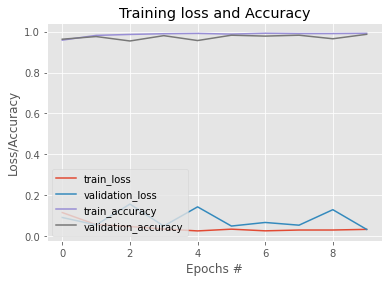

In [25]:
n = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n), h.history["loss"], label = "train_loss")
plt.plot(np.arange(0, n), h.history["val_loss"], label = "validation_loss")
plt.plot(np.arange(0, n), h.history["accuracy"], label = "train_accuracy")
plt.plot(np.arange(0, n), h.history["val_accuracy"], label = "validation_accuracy")
plt.title("Training loss and Accuracy")
plt.xlabel("Epochs #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
